# Lecture 6.2: Multiple Regression

## Outline  

* Prediction with regression
    * Confidence interval vs prediction interval
* Multiple regression
    * Fitting multiple variables
    * Interpretation of the model
    * Adjusted $R^2$
    * F-test

## Objectives

* Understand the difference between confidence interval and prediction interval for regression predictions  
* Fit and interpret multiple regression models
* Understand the idea of adjusted $R^2$ and know when to use it  
* Carry out overall F test 

## Prediction with Regression

In [1]:
%pylab inline

import pandas as pd
import statsmodels.api as sm
import yaml

from seaborn import pairplot
from sqlalchemy import create_engine

pg_creds = yaml.load(open('../../pg_creds.yaml'))['student']

engine = create_engine('postgresql://{user}:{password}@{host}:{port}/{dbname}'.format(**pg_creds))

cars = pd.read_sql("SELECT * FROM cars WHERE horsepower IS NOT NULL;", engine, index_col='index')

Populating the interactive namespace from numpy and matplotlib


In [2]:
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
index,,,,,,,,,
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


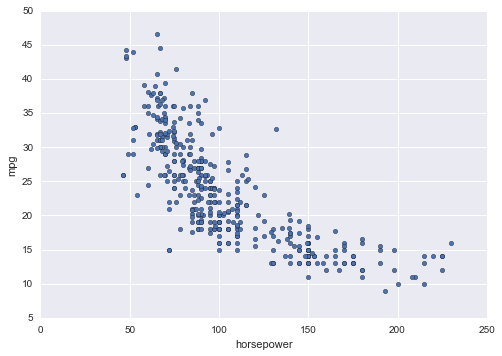

In [3]:
cars.plot('horsepower', 'mpg', kind='scatter');

In [4]:
X = cars.horsepower
X = sm.add_constant(X)
y = cars.mpg

model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Tue, 04 Oct 2016   Prob (F-statistic):           7.03e-81
Time:                        13:50:41   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.000        38.525    41.347
horsepower    -0.1578      0.006    -24.489      0.000        -0.171    -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For a car that has 200 horsepower, what mpg do we expected it to have?

$$\hat{y} = b_0 + b_1 x $$  

$$ \hat{y} = 39.9359 - 0.1578 (200) = 8.4 $$

In [10]:
results.predict([1, 200])

array([ 8.36691435])

### Reporting the Results

* A regression on the basis of a random sample of a bunch of cars indicates that an additional 1 horsepower decreases the miles per gallon by 0.158 on average.  

* This effect is substantial and statistically significant.  

* The regression line explains 60% of the variation in miles per gallon.  

* A car with 200 horsepower is expected to have a mpg of 8.4.

What about the mpg of a car with 250 horsepower?

**Caution**: error of extrapolation.

### Bounding the Prediction  

* The predicted mpg for 200 horsepower is 8.4.  

* This is just a guess, and we need to put bounds on how good a guess it is.  

* A weird aspect of regression is we could estimate the average mpg for all the cars that have 200 horsepower, or the mpg for a particular car that has 200 horsepower.  

* What? Average or Particular.  

#### Predicting an Average  

* Say we fit a regression model and obtained the estimates $s$, $b_0$ and $b_1$.  

* We now have a new $X$ value, $x_{new}$  

* The regression model says that  

$$ E(Y_{new} | X_{new}) = \beta_0 + \beta_1 X_{new} $$  

* so our guess for the average value of $Y$ given $X_{new}$ is  

$$ \hat{y}_{new} = b_0 + b_1 x_{new} $$

#### Confidence Interval for an Average  

The confidence interval for  

$$ E(Y_{new} | X_{new}) = \beta_0 + \beta_1 X_{new} $$  

is given by  

$$ b_0 + b_1 x_{new} \pm 1.96 \left[ s_e  \left( \frac{1}{n} + \frac{(x_{new} - \bar{x})^2}{(n - 1) s_X^2} \right) ^ {1/2} \right] $$

In [11]:
x = cars.horsepower
se = sqrt(results.mse_resid)
b0, b1 = results.params

x_new = 200

def confidence_se(s_e, x, x_new):
    mean_x = x.mean()
    var_x = x.var()
    n = len(x)
    return s_e * (1/n + (x_new - mean_x)**2 / ((n - 1) * var_x))**0.5

sign = array([-1., 1.])
b0 + b1 * x_new + sign * 1.96 * confidence_se(se, x, x_new)

array([ 7.06601026,  9.66781844])

#### Predicting a Particular Value  

* Say we fit a regression model and obtained the estimates $s$, $b_0$ and $b_1$.  

* We now have a new $X$ value, $x_{new}$  

* The regression model says that  

$$ Y_{new} = \beta_0 + \beta_1 X_{new} + \varepsilon $$  

* so our guess for the new value of $Y$ is  

$$ \hat{y}_{new} = b_0 + b_1 x_{new} $$

**Interesting**  

* Our guess for the expected value of $Y$ and for the predicted value of $Y$ is the same!!  

* The only difference will be in accuracy - the guess for the expected value is more accurate.  

* That is because for a particular value, we have no idea what the noise is and we have to account for that when we make the prediction interval.

#### The Prediction Interval  

The prediction interval for 

$$ Y_{new} = \beta_0 + \beta_1 X_{new} + \varepsilon $$  

is given by  

$$ b_0 + b_1 x_{new} \pm 1.96 \left[ s_e  \left( 1 + \frac{1}{n} + \frac{(x_{new} - \bar{x})^2}{(n - 1) s_X^2} \right) ^ {1/2} \right] $$  


In our car example, this gives us a confidence interval for the `mpg` of a particular car that has 200 horsepower.  

In [12]:
def prediction_se(s_e, x, x_new):
    mean_x = x.mean()
    var_x = x.var()
    n = len(x)
    return s_e * (1 + 1/n + (x_new - mean_x)**2 / ((n - 1) * var_x))**0.5

b0 + b1 * x_new + sign * 1.96 * prediction_se(se, x, x_new)

array([ -1.33597334,  18.06980204])

#### Confidence vs Prediction

<img src="images/conf_pred.png" width="600">  

**Note**: the prediction interval is always bigger than the confidence interval.

## Multiple Regression  

Instead of using `horsepower` as the only independent variable to predict `mpg`, we might want to include other independent variables in the model.  

Let's try to add `weight` to the model.

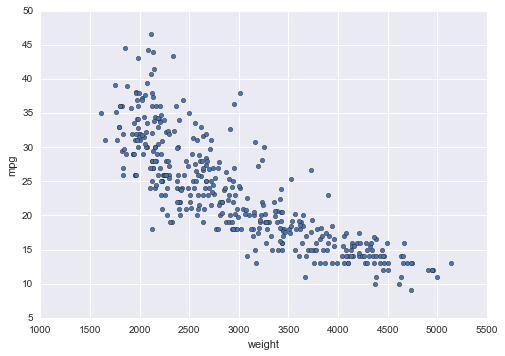

In [13]:
cars.plot('weight', 'mpg', kind='scatter');

In [14]:
X2 = cars[['horsepower', 'weight']]
X2 = sm.add_constant(X2)
y2 = cars.mpg

model2 = sm.OLS(y2, X2)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     467.9
Date:                Tue, 04 Oct 2016   Prob (F-statistic):          3.06e-104
Time:                        13:58:09   Log-Likelihood:                -1121.0
No. Observations:                 392   AIC:                             2248.
Df Residuals:                     389   BIC:                             2260.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         45.6402      0.793     57.540      0.000        44.081    47.200
horsepower    -0.0473      0.011     -4.267      0.000        -0.069    -0.026
weight        -0.0058      0.001    -11.535      0.000        -0.007    -0.005
==============================================================================
Omnibus:                       35.336   Durbin-Watson:                   0.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.973
Skew:                           0.683   Prob(JB):                     1.04e-10
Kurtosis:                       3.974   Cond. No.                     1.15e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So our multiple regression model is give by  

$$ \hat{mpg} = 45.6402 - 0.0473 \times horsepower - 0.0058 \times weight $$

Model fit?  

Our model explains about 70% of the variation in `mpg`.

Model interpretation?  

* **Holding `weight` constant**, we would expect `mpg` to decrease by 0.047 as `horsepower` goes up by 1.  

* **Holding `horsepower` constant**, we would expect `mpg` to decrease by 0.006 as `weight` increases by 1.  

* What does the intercept mean here?

What is the predicted `mpg` for a car with 200 `horsepower` and a `weight` of 3500?

$$ \hat{mpg} = 45.6402 - 0.0473 (200) - 0.0058 (3500) = 15.88 $$  


We would expected the `mpg` of the car to be 15.88.

### The Multiple Regression Model

Multiple linear regression is very similar to simple linear regression except that the dependent variable $y$ is described by $k$ independent variables $x_1, \dots, x_k$  

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_k x_k + \varepsilon $$  

**Our predicted model**  

$$\hat{y} = b_0 + b_1 x_1 + b_2 x_2 + \dots + b_k x_k$$

* The interpretation of the intercept is the same  
* Slope $b_i$ is the change in $y$ given a unit change in $x_i$ while **holding all other variables constant**  
* SST, SSE, SSR, and $R^2$ are the same  
* $s_e$ is almost the same except now $s_e = \sqrt{ SSE / (n-k-1) }$  
* Slope coefficient C.I.s are the same  
* p-values (one for each $x_i$) are the same  

**Example**  

Now let's try to predict `mpg` using `displacement`, `horsepower`, `weight` and `acceleration`. 

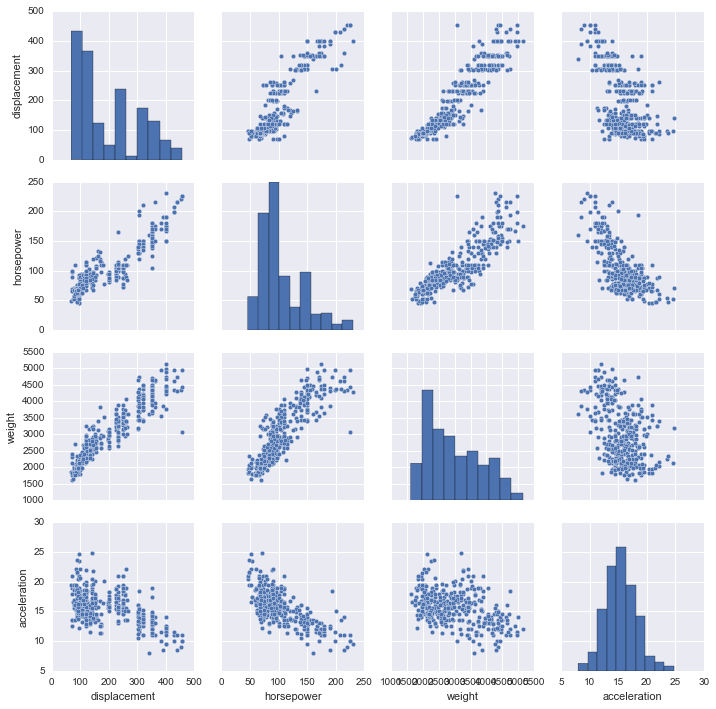

In [15]:
X3 = cars[['displacement', 'horsepower', 'weight', 'acceleration']]
pairplot(X3);

In [16]:
X3 = sm.add_constant(X3)
y3 = cars.mpg

model3 = sm.OLS(y3, X3)
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     233.4
Date:                Tue, 04 Oct 2016   Prob (F-statistic):          9.63e-102
Time:                        14:12:41   Log-Likelihood:                -1120.6
No. Observations:                 392   AIC:                             2251.
Df Residuals:                     387   BIC:                             2271.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           45.2511      2.456     18.424      0.000        40.422    50.080
displacement    -0.0060      0.007     -0.894      0.372        -0.019     0.007
horsepower      -0.0436      0.017     -2.631      0.009        -0.076    -0.011
weight          -0.0053      0.001     -6.512      0.000        -0.007    -0.004
acceleration    -0.0231      0.126     -0.184      0.854        -0.270     0.224
==============================================================================
Omnibus:                       38.359   Durbin-Watson:                   0.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.333
Skew:                           0.715   Prob(JB):                     7.13e-12
Kurtosis:                       4.049   Cond. No.                     3.56e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

What is our regression equation?

$$ \hat{mpg} = 45.2511 - 0.0060 \times displacement - 0.0436 \times horsepower - 0.0053 \times weight - 0.0231 \times acceleration $$

How good is the model fit?

How do we interpret the model?

Is it a good idea to include `displacement` in the model?

### Adjusted $R^2$  

People love $R^2$.  

This leads to an overwhelming temptation to put lots of $X$’s in.  

This is a bad attitude. We want to summarize and predict, and we want to do it in the simplest possible way. The more complicated a model is, the less useful it tends to be. Of course it has to be “complicated enough” to capture the important features of the data.

The adjusted $R^2$ is designed to build in an automatic penalty for adding an $X$.  

$$R_a^2 = 1 - \frac{\frac{1}{n - k - 1} SSE}{\frac{1}{n - 1} SST} $$  

We use adjusted $R^2$ when we compare models with different numbers of independent variables (more on this tomorrow).

According to the adjusted $R^2$, which is the best model we have fitted so far?

### The Overall F Test  

Instead of testing if one independent variable is useful for predicting the dependent variable, we might want to test if the model as a whole is useful for predicting the dependent variable.  

For that, we use the F test.  

* It tests the null hypothesis:  

$$ H_0: \beta_1 = \beta_2 = \dots = \beta_k = 0$$  

* Under the null hypothesis, there are no $X$ variables in the model.  

* The alternative hypothesis:  

$$ H_a: \text{ at least one } \beta_i \neq 0 $$  

**Test statistic**  

$$f = \frac{\frac{SSR}{k}}{\frac{SSE}{(n - k - 1)}}$$ 

The larger the value of $f$, the stronger the evidence to reject the null.  

The test statistic follows an F distribution, and we find the p-value by comparing the test statistic to an F distribution with degress of freedom $k$ and $n - k - 1$.   

We will simply read the p-value from the regression output. (Score!)

In [17]:
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     233.4
Date:                Tue, 04 Oct 2016   Prob (F-statistic):          9.63e-102
Time:                        14:18:09   Log-Likelihood:                -1120.6
No. Observations:                 392   AIC:                             2251.
Df Residuals:                     387   BIC:                             2271.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           45.2511      2.456     18.424      0.000        40.422    50.080
displacement    -0.0060      0.007     -0.894      0.372        -0.019     0.007
horsepower      -0.0436      0.017     -2.631      0.009        -0.076    -0.011
weight          -0.0053      0.001     -6.512      0.000        -0.007    -0.004
acceleration    -0.0231      0.126     -0.184      0.854        -0.270     0.224
==============================================================================
Omnibus:                       38.359   Durbin-Watson:                   0.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.333
Skew:                           0.715   Prob(JB):                     7.13e-12
Kurtosis:                       4.049   Cond. No.                     3.56e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$$\text{F-statistic} = 233.4$$
$$\text{p-value} = 9.63 \times 10^{-102} $$   

We have extremely strong evidence to conclude that the at least one of the variables in the model is useful for predicting `mpg`.

Is Model 1 (with one variable `horsepower`) useful for predicting `mpg`?

In [18]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Tue, 04 Oct 2016   Prob (F-statistic):           7.03e-81
Time:                        14:20:16   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.000        38.525    41.347
horsepower    -0.1578      0.006    -24.489      0.000        -0.171    -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Is Model 2 (with two variables `horsepower` and `weight`) useful for predicting `mpg`?

In [19]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     467.9
Date:                Tue, 04 Oct 2016   Prob (F-statistic):          3.06e-104
Time:                        14:20:19   Log-Likelihood:                -1121.0
No. Observations:                 392   AIC:                             2248.
Df Residuals:                     389   BIC:                             2260.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         45.6402      0.793     57.540      0.000        44.081    47.200
horsepower    -0.0473      0.011     -4.267      0.000        -0.069    -0.026
weight        -0.0058      0.001    -11.535      0.000        -0.007    -0.005
==============================================================================
Omnibus:                       35.336   Durbin-Watson:                   0.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.973
Skew:                           0.683   Prob(JB):                     1.04e-10
Kurtosis:                       3.974   Cond. No.                     1.15e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""